In [34]:
import sys
sys.path.append('../')
from src import load_dataset

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import FrenchStemmer
from wordcloud import WordCloud

In [35]:
X, y = load_dataset()

In [36]:
stemmer = FrenchStemmer()
stopwords_list = stopwords.words('french')[:66] #on cut avant les différentes formes du verbe être/avoir qui seront handle par le stemmer


class Mixed_analyzer():
    def __init__(self, baseVectorizer=CountVectorizer(), stemmer=None) -> None:
        """
        :param baseVectorizer : un vectorizer de Sklearn déjà custom sans analyser
        :param stemmer : un stemmer si besoin
        """
        self.preprocess = baseVectorizer.build_preprocessor()
        self.tokenizer = baseVectorizer.build_tokenizer()
        self.analyzer = baseVectorizer.build_analyzer()

        self.stemmer = stemmer

    def __call__(self, doc):
        """
        Stem avec nltk + regarde les stopwords
        """
        # Preprocessing : 
        #   Takes an entire document as input (as a single string), and returns a possibly transformed version of the document, still as an entire string. 
        #   This can be used to remove HTML tags, lowercase the entire document, etc.
        # preprocess_doc = preprocess(doc)
    
        # Tokenizer :
        #   a callable that takes the output from the preprocessor 
        #   and splits it into tokens, then returns a list of these.
        
        # N-gram extraction and stop word filtering take place at the analyzer level
        
        # Ici il preprocess + tokenise à partir du baseVectorizer
        # * strip accent
        # * Stop word
        tokenized_list = self.analyzer(doc)
    
        # Stemming
        if self.stemmer != None:
            return [stemmer.stem(w) for w in tokenized_list]
        return tokenized_list
    
        # return tokenized_list

In [37]:
mixed_analyzer = Mixed_analyzer(CountVectorizer(
    strip_accents="ascii",
    stop_words=stopwords_list
), FrenchStemmer())

vectorizer = CountVectorizer(
    analyzer=mixed_analyzer,
    )
X_transformed = vectorizer.fit_transform(X)

/home/charles/.local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['meme'] not in stop_words.
  warnings.warn(


In [38]:
words = vectorizer.get_feature_names_out()
words[400:500]

array(['absenc', 'absent', 'absente', 'absolu', 'absolus', 'absolut',
       'absorb', 'absorpt', 'absten', 'abstent', 'abstention', 'abstenu',
       'abstract', 'abstrair', 'abstrait', 'absurd', 'absurdit', 'abuj',
       'abus', 'abym', 'acad', 'academ', 'academicien', 'acadien',
       'acapulco', 'accabl', 'accablent', 'accapar', 'acce', 'acced',
       'accedent', 'accederent', 'accel', 'acceler', 'accelere',
       'accelerent', 'accent', 'accentu', 'accentue', 'accentuent',
       'accept', 'accepte', 'acceptent', 'accepton', 'access',
       'accessibilit', 'accessibl', 'accessoir', 'accident', 'accidentel',
       'acclam', 'acclimat', 'accol', 'accommod', 'accommodent',
       'accomod', 'accompagn', 'accompagne', 'accompagnent',
       'accompagnon', 'accompl', 'accord', 'accorde', 'accordent',
       'accordon', 'accost', 'accouch', 'accourt', 'accredit', 'accroch',
       'accrochag', 'accroche', 'accroiss', 'accroissement',
       'accroissent', 'accroit', 'accroitr', 'a

# Prediction

<AxesSubplot: >

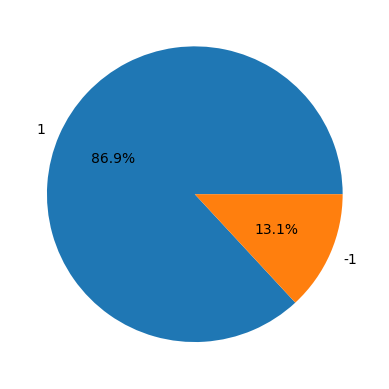

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
# plt.plot(y, kind=pie)
pd.Series(y).value_counts().plot.pie(autopct='%1.1f%%')

Un des deux ne parle pas beaucoup. Il vas falloir équilibrer les classes

Utilisons un [Random over sampler](https://imbalanced-learn.org/stable/over_sampling.html#random-over-sampler)

"Nombre d'exemple avant over sampling: 57413, après oversampling : 99780"

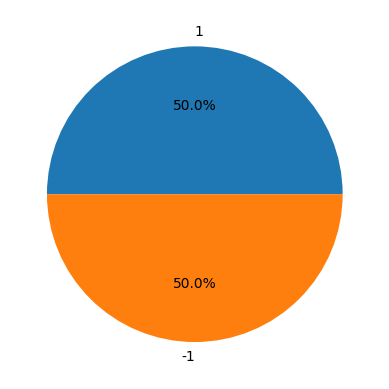

In [41]:
from sklearn.model_selection import train_test_split

# with a seed to enhence reproducibility
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.4, random_state=0)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_ROS, y_ROS = ros.fit_resample(X_trai, y)
pd.Series(y_ROS).value_counts().plot.pie(autopct='%1.1f%%')
f"Nombre d'exemple avant over sampling: {len(y)}, après oversampling : {len(y_ROS)}"

In [42]:
from asyncore import write
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from src import write_classif_report

#Naïve Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',max_iter=100,n_jobs=-1)
lr_clf.fit(X_train, y_train)

#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5)
svm_clf.fit(X_train, y_train)

pred_nb = nb_clf.predict(X_test)
pred_lr = lr_clf.predict(X_test)
pred_svm = svm_clf.predict(X_test)


print(f"Naïve Bayes accuracy: \n {classification_report(y_test, pred_nb)}")
print(f"Logistic Regression accuracy: \n {classification_report(y_test, pred_lr)}")
print(f"SVM accuracy: \n {classification_report(y_test, pred_svm)}")

/home/charles/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Naïve Bayes accuracy: 
               precision    recall  f1-score   support

          -1       0.57      0.41      0.48      2998
           1       0.91      0.95      0.93     19968

    accuracy                           0.88     22966
   macro avg       0.74      0.68      0.71     22966
weighted avg       0.87      0.88      0.87     22966

Logistic Regression accuracy: 
               precision    recall  f1-score   support

          -1       0.70      0.35      0.47      2998
           1       0.91      0.98      0.94     19968

    accuracy                           0.90     22966
   macro avg       0.80      0.67      0.71     22966
weighted avg       0.88      0.90      0.88     22966

SVM accuracy: 
               precision    recall  f1-score   support

          -1       0.58      0.41      0.48      2998
           1       0.91      0.96      0.93     19968

    accuracy                           0.88     22966
   macro avg       0.75      0.68      0.71     22966
we

/home/charles/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [43]:
# write_classif_report(y_test, pred_lr, name="Lr_Accent_NltkStopword_NltkStemmer")

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_ROS, y_ROS, test_size=0.4, random_state=0)
#Naïve Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',max_iter=100,n_jobs=-1)
lr_clf.fit(X_train, y_train)

#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5)
svm_clf.fit(X_train, y_train)

pred_nb = nb_clf.predict(X_test)
pred_lr = lr_clf.predict(X_test)
pred_svm = svm_clf.predict(X_test)


print(f"Naïve Bayes accuracy: \n {classification_report(y_test, pred_nb)}")
print(f"Logistic Regression accuracy: \n {classification_report(y_test, pred_lr)}")
print(f"SVM accuracy: \n {classification_report(y_test, pred_svm)}")

/home/charles/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Naïve Bayes accuracy: 
               precision    recall  f1-score   support

          -1       0.83      0.75      0.79     20082
           1       0.77      0.84      0.80     19830

    accuracy                           0.80     39912
   macro avg       0.80      0.80      0.80     39912
weighted avg       0.80      0.80      0.80     39912

Logistic Regression accuracy: 
               precision    recall  f1-score   support

          -1       0.84      0.93      0.88     20082
           1       0.92      0.82      0.87     19830

    accuracy                           0.87     39912
   macro avg       0.88      0.87      0.87     39912
weighted avg       0.88      0.87      0.87     39912

SVM accuracy: 
               precision    recall  f1-score   support

          -1       0.85      0.93      0.88     20082
           1       0.92      0.83      0.87     19830

    accuracy                           0.88     39912
   macro avg       0.88      0.88      0.88     39912
we

/home/charles/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
